Previsão do atraso de cargas 

In [1]:
import pandas as pd
import numpy as np  
import xgboost as xgb
import matplotlib.pyplot as plt
import seaborn as sns
import subprocess
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_curve, auc
from sklearn.tree import DecisionTreeClassifier

In [2]:
df = pd.read_excel(r"C:\analise\Compilado_teste.xlsx")

In [6]:
df['EmissaoNota'] = pd.to_datetime(df['EmissaoNota'], errors='coerce')
df['MES'] = df['EmissaoNota'].dt.month
df['ANOMES'] = df['EmissaoNota'].dt.to_period('M')
df['SEMESTRE'] = (df['EmissaoNota'].dt.month - 1) // 6 + 1
df['DIASEMANA'] = df['EmissaoNota'].dt.dayofweek

In [10]:
# Separe as variáveis preditoras (features) da variável resposta (target)
X = df.drop('Avaliacao', axis=1) #Substitua 'target_column' pelo nome da coluna de destino
y = df['Avaliacao']

# Divida os dados em conjuntos de treinamento e teste
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:

# Definir as colunas a serem utilizadas
selected_columns = [
    "Origem", "Tomador", "UFDestino", "MES", "SEMESTRE", "DIASEMANA", 
    "Agenda", "TDE", "DEDICADO", "Avaliacao", "Parceiro", "CNPJDestino", 
    "Destino", "ANOMES"
]

# Filtrar o DataFrame apenas com as colunas necessárias
df = df[selected_columns]

# Converter colunas categóricas para tipo 'category'
categorical_columns = ["Origem", "Tomador", "UFDestino", "DIASEMANA", 
                        "Agenda", "Parceiro", "Destino"]

df[categorical_columns] = df[categorical_columns].astype("category")

# Converter ANOMES para inteiro, garantindo que ele está no formato correto
if "ANOMES" in df.columns:
    df["ANOMES"] = df["ANOMES"].astype(str).str.replace("-", "").astype(int)

# Converter a variável alvo 'Avaliacao' para valores numéricos
label_encoder = LabelEncoder()
df["Avaliacao"] = label_encoder.fit_transform(df["Avaliacao"])  # 'ATRASOU' -> 0, 'CUMPRIU' -> 1

# Separar X (features) e y (target)
X = df.drop("Avaliacao", axis=1)
y = df["Avaliacao"]

# Dividir os dados em treino e teste
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Criar modelo XGBoost com os hiperparâmetros especificados
model = xgb.XGBClassifier(
    subsample=0.8,
    n_estimators=300,
    max_depth=9,
    learning_rate=0.2,
    gamma=0.2,
    colsample_bytree=0.7,
    enable_categorical=True,
    random_state=42
)

# Treinar o modelo
model.fit(X_train, y_train)

# Fazer previsões
y_pred = model.predict(X_test)

# Avaliar a precisão
accuracy = accuracy_score(y_test, y_pred)
print("Acurácia:", accuracy)


Acurácia: 0.8613923343390323


Acurácia: 0.8613923343390323


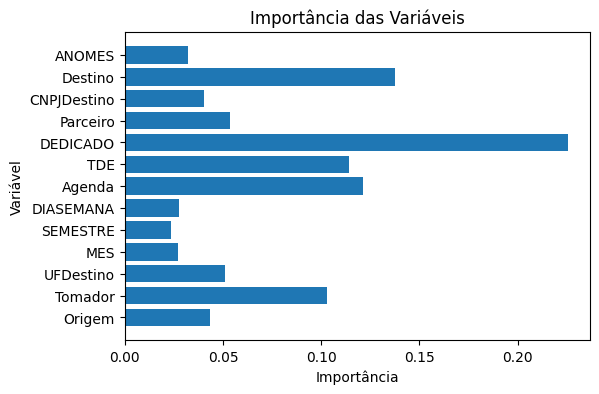

In [17]:
accuracy = accuracy_score(y_test, y_pred)
print("Acurácia:", accuracy)


importances = model.feature_importances_


feature_names = X.columns


plt.figure(figsize=(6, 4))
plt.barh(range(len(importances)), importances, tick_label=feature_names)
plt.xlabel('Importância')
plt.ylabel('Variável')
plt.title('Importância das Variáveis')
plt.show()

In [18]:
accuracy = accuracy_score(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)
class_report = classification_report(y_test, y_pred)

print("Acurácia:", accuracy)
print("Matriz de Confusão:")
print(conf_matrix)
print("Relatório de Classificação:")
print(class_report)

Acurácia: 0.8613923343390323
Matriz de Confusão:
[[ 5584  4408]
 [ 1794 32959]]
Relatório de Classificação:
              precision    recall  f1-score   support

           0       0.76      0.56      0.64      9992
           1       0.88      0.95      0.91     34753

    accuracy                           0.86     44745
   macro avg       0.82      0.75      0.78     44745
weighted avg       0.85      0.86      0.85     44745



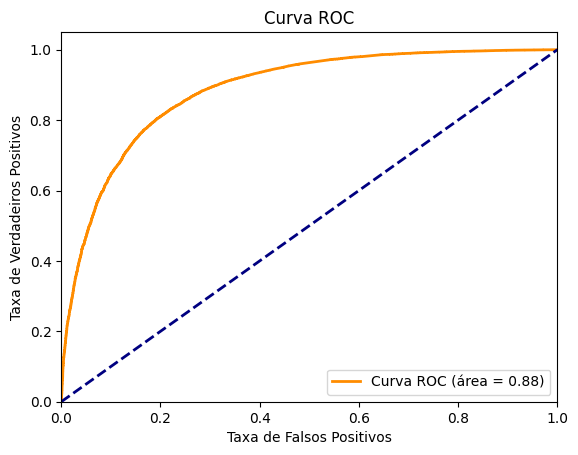

In [19]:
y_pred_proba = model.predict_proba(X_test)[:, 1]
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='Curva ROC (área = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Taxa de Falsos Positivos')
plt.ylabel('Taxa de Verdadeiros Positivos')
plt.title('Curva ROC')
plt.legend(loc="lower right")
plt.show()